# Compare Graph Distributions using MMD as evaluator function

[1] https://github.com/BorgwardtLab/ggme

### Load dependencies, including the graph evaluation library

In [ ]:
import sys, os
GRAPH_EVAL_PATH = os.path.abspath('ggme/src/')
sys.path.append(GRAPH_EVAL_PATH)

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

import numpy as np
import torch
from torch_geometric.utils import to_networkx
import networkx as nx
import matplotlib.pyplot as plt

from evaluate import evaluate_mmd
from correlation import compute_correlation
from metrics.kernels import gaussian_kernel
from metrics.descriptor_functions import degree_distribution, clustering_coefficient, normalised_laplacian_spectrum

### Helper functions to load networkx graphs

In [15]:
def get_pyg_graphs(ouput_base_dir, grid_type, split='train'):
    dataset_path = os.path.join(ouput_base_dir, grid_type, split, f'dataset_{split}.pt')
    pyg_dataset = torch.load(dataset_path, weights_only=False)
    return pyg_dataset

def get_networkx_graph(data):
    return to_networkx(data, node_attrs='x', to_undirected='upper')

### Helper functions to do graph comparisons

In [41]:
def find_best_sigma(nx_graphs_ref, nx_graphs_eval, desc_func, kernel, **kwargs):
    test_sigmas = [10**x for x in range(-10, 10)]
    mmds = [evaluate_mmd(
            graphs_dist_1=nx_graphs_ref,
            graphs_dist_2=nx_graphs_eval,
            function=desc_func,
            kernel=kernel,
            use_linear_approximation=False,
            sigma=sigma,
            **kwargs
            ) for sigma in test_sigmas]
    plt.xlabel("sigma")
    plt.xscale("log")
    plt.ylabel("mmd")
    plt.yscale("linear")
    plt.plot(test_sigmas, mmds, '-o', label=desc_func.__name__)
    plt.legend()

    mmd_peak = 0
    sigma_peak = -1
    for sigma, mmd in zip(test_sigmas, mmds):
        if mmd > mmd_peak:
            mmd_peak = mmd
            sigma_peak = sigma

    return (sigma_peak, mmd_peak)

def analyze_graphs(nx_graphs_ref, nx_graphs_eval):
    # Degree Distrubtion
    sigma_mmd = find_best_sigma(nx_graphs_ref,
                                nx_graphs_eval,
                                degree_distribution,
                                gaussian_kernel,
                                density=True)
    print('Degree Distribution (sigma, mmd): ', sigma_mmd)
    
    # Laplacian Spectrum
    sigma_mmd = find_best_sigma(nx_graphs_ref,
                                nx_graphs_eval,
                                normalised_laplacian_spectrum,
                                gaussian_kernel,
                                density=True)
    print('Laplacian Spectrum (sigma, mmd): ', sigma_mmd)
    
    # Clustering Coefficient
    # Not a very helpful descriptor b/c converges to zero for radial distribution feeders
    # sigma_mmd = find_best_sigma(nx_graphs_ref,
    #                             nx_graphs_eval,
    #                             clustering_coefficient,
    #                             gaussian_kernel,
    #                             density=True)
    

### Load graphs, and evaluate distributions using MMD

In [ ]:
OUTPUT_BASE_DIR = 'outputs/2024-12-30_19:23:46/'
ALL_GRIDS = {
    '1-LV-rural1--0-no_sw': (0,0),
    '1-LV-rural2--0-no_sw': (0,0),
    '1-LV-rural3--0-no_sw': (0,0),
    '1-LV-semiurb4--0-no_sw': (0,0),
    '1-LV-semiurb5--0-no_sw': (0,0),
    '1-LV-urban6--0-no_sw': (0,0),
    '1-MV-comm--0-no_sw': (0,0),
    '1-MV-rural--0-no_sw': (0,0),
    '1-MV-semiurb--0-no_sw': (0,0),
    '1-MV-urban--0-no_sw': (0,0)
}

# Create the NX graphs and fill their indices in ALL_GRIDS
NX_GRAPHS = []
start = 0
for grid in ALL_GRIDS.keys():
    nx_graphs = [get_networkx_graph(pyg_graph) for pyg_graph in get_pyg_graphs(OUTPUT_BASE_DIR, grid)]
    NX_GRAPHS.extend(nx_graphs)
    end = start + len(nx_graphs)
    ALL_GRIDS[grid] = (start, end)
    start = end

Grid: 1-LV-rural1--0-no_sw
Degree Distribution (sigma, mmd):  (100, 1.4158628906586717)
Laplacian Spectrum (sigma, mmd):  (0.01, 1.3294414840100315)


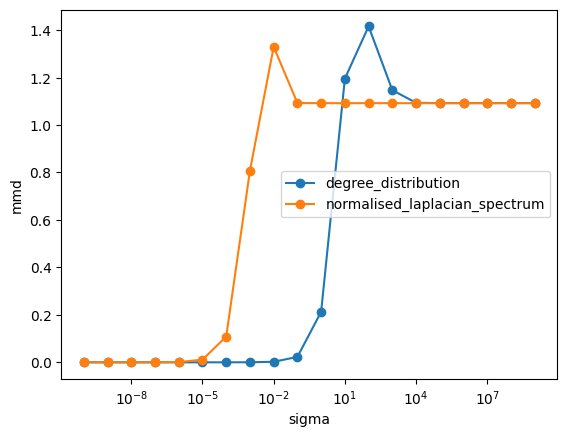

In [45]:
# Test
grid = '1-LV-rural1--0-no_sw'
start, end = ALL_GRIDS[grid]
nx_graphs_ref = NX_GRAPHS[start:end]
nx_graphs_eval = NX_GRAPHS[0:start] + NX_GRAPHS[end:]
print('Grid:', grid)
analyze_graphs(nx_graphs_ref, nx_graphs_eval)
plt.show(block=False)
print(flush=True)

### Analyze the graphs for the best sigma, using a different reference grid each time

Grid: 1-LV-rural1--0-no_sw
Degree Distribution (sigma, mmd):  (100, 1.4158628906586717)
Laplacian Spectrum (sigma, mmd):  (0.01, 1.3294414840100315)


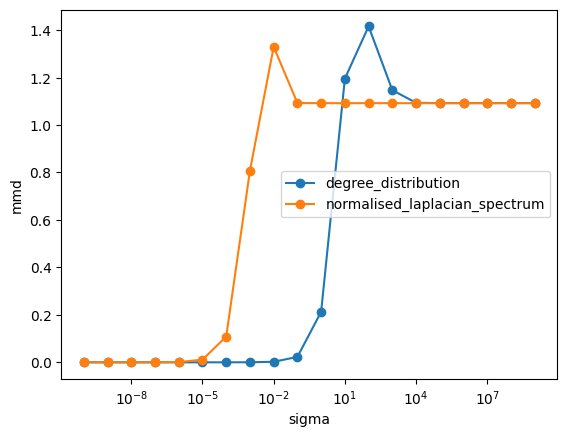


Grid: 1-LV-rural2--0-no_sw
Degree Distribution (sigma, mmd):  (1000, 1.1424142342552606)
Laplacian Spectrum (sigma, mmd):  (0.1, 1.0925734152646092)


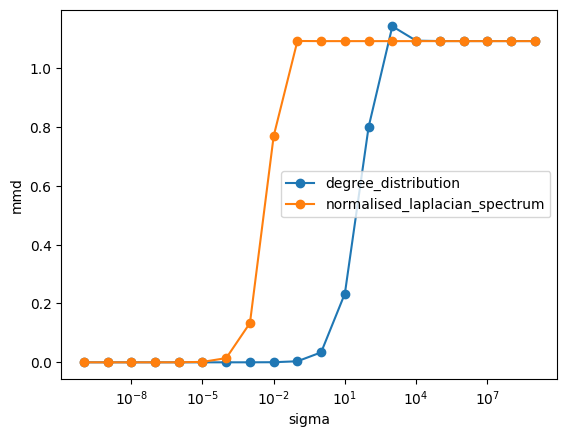


Grid: 1-LV-rural3--0-no_sw
Degree Distribution (sigma, mmd):  (10000, 1.0936742344580113)
Laplacian Spectrum (sigma, mmd):  (0.1, 1.092452202573611)


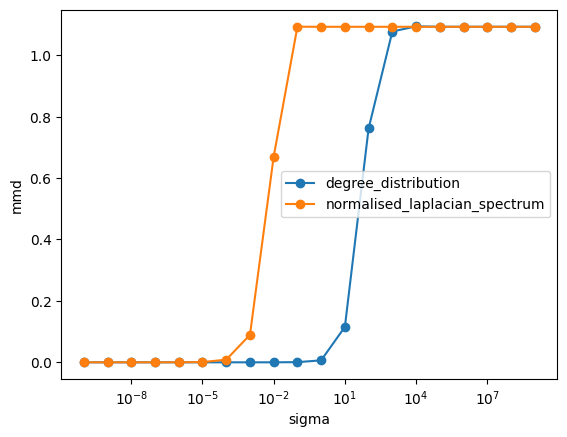


Grid: 1-LV-semiurb4--0-no_sw
Degree Distribution (sigma, mmd):  (10000, 1.0936742344580113)
Laplacian Spectrum (sigma, mmd):  (0.01, 1.1113731898924293)


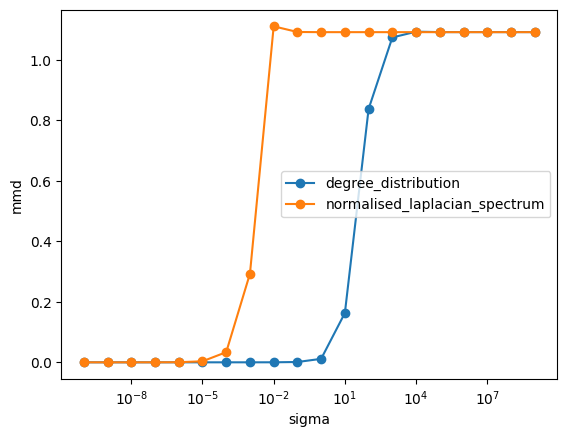


Grid: 1-LV-semiurb5--0-no_sw
Degree Distribution (sigma, mmd):  (1000, 1.14401340717673)
Laplacian Spectrum (sigma, mmd):  (0.1, 1.0925076258825328)


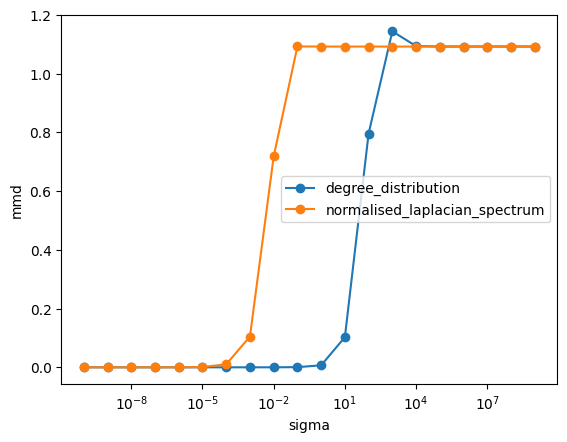


Grid: 1-LV-urban6--0-no_sw
Degree Distribution (sigma, mmd):  (1000, 1.1411848479169764)
Laplacian Spectrum (sigma, mmd):  (0.1, 1.0926387271856859)


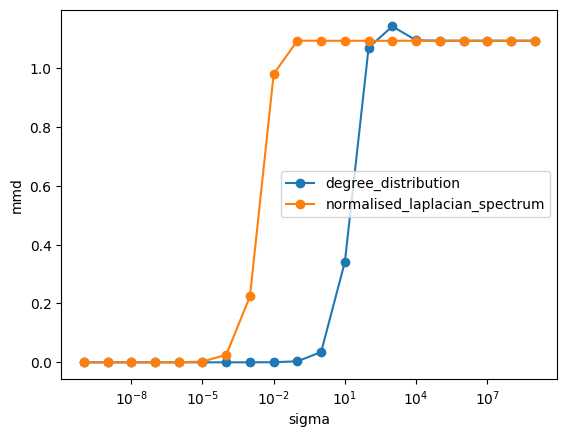


Grid: 1-MV-comm--0-no_sw
Degree Distribution (sigma, mmd):  (1000, 0.7872042082173665)
Laplacian Spectrum (sigma, mmd):  (0.01, 0.6535260046327769)


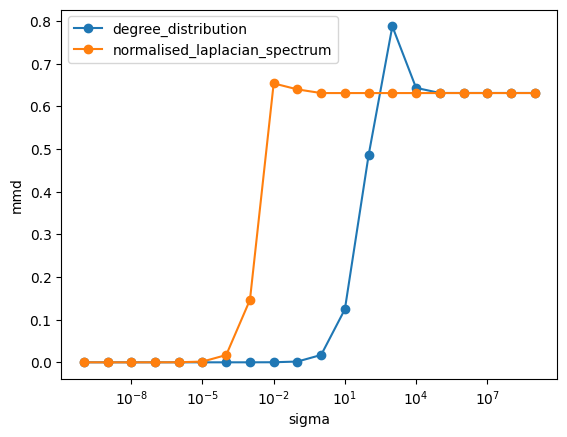


Grid: 1-MV-rural--0-no_sw
Degree Distribution (sigma, mmd):  (100000, 1.0923162762307435)
Laplacian Spectrum (sigma, mmd):  (0.1, 1.0926175406595484)


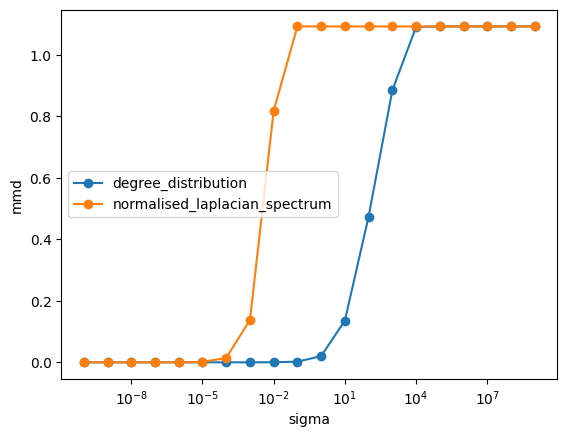


Grid: 1-MV-semiurb--0-no_sw
Degree Distribution (sigma, mmd):  (10000, 0.9893754634235972)
Laplacian Spectrum (sigma, mmd):  (0.1, 0.9610952231742824)


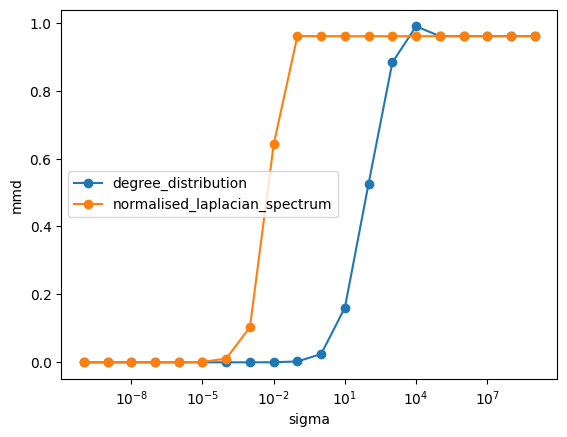


Grid: 1-MV-urban--0-no_sw
Degree Distribution (sigma, mmd):  (1000, 0.984932016688535)
Laplacian Spectrum (sigma, mmd):  (0.1, 0.6668263440505635)


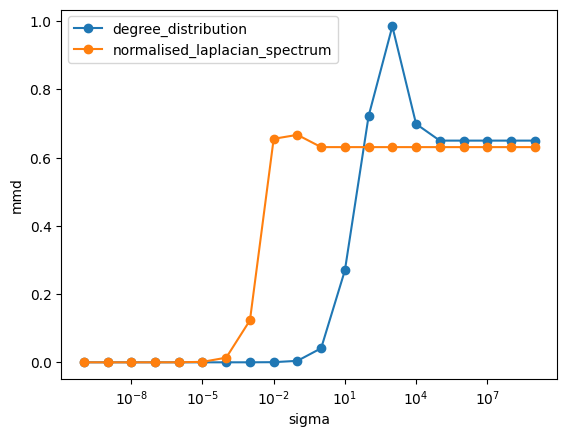

In [43]:
for grid in ALL_GRIDS.keys():
    start, end = ALL_GRIDS[grid]
    nx_graphs_ref = NX_GRAPHS[start:end]
    nx_graphs_eval = NX_GRAPHS[0:start] + NX_GRAPHS[end:]
    print('Grid:', grid)
    analyze_graphs(nx_graphs_ref, nx_graphs_eval)
    plt.show(block=False)
    print(flush=True)

### Conclusion
#### We can analyze the different sigmas and choose the one that works the best on average for each descriptor function. We do not necessarily always choose the sigma with the largest mmd because it flattens out at some point. We choose a relatively high mmd, where there is some activity.
#### Degree Distribution (sigma): 1000
#### Laplacian Spectrum (sigma): 0.01

## Appendix

### Clustering Coefficient as descriptor function

Clustering coefficient converges to zero for radial distribution feeders due to their tree structures, and in general there is not much difference using clustering coefficient as a descriptor. This can be shown with the distance of 0 for all sigmas.

(-1, 0)

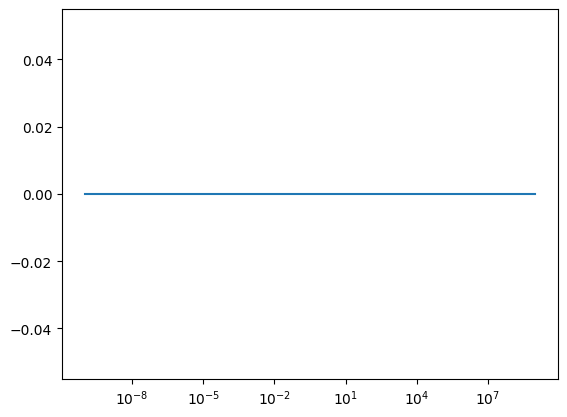

In [ ]:
nx_graphs_ref = NX_GRAPHS[0:1]
nx_graphs_eval = NX_GRAPHS[1:]
find_best_sigma(nx_graphs_ref,
                nx_graphs_eval,
                clustering_coefficient,
                gaussian_kernel,
                density=True)

### Testing correlations with MMD

We want to test correlations. Here we just correlate the test sigmas to the MMD, just to see how the function works, but usually we would correlate the RMSEs and the MMDs.  
We use both the Pearson and the Spearman correlation.  
The main difference between Pearson and Spearman correlation is that Pearson assumes a linear relationship between data, while Spearman checks for a monotonic relationship (when one variable increases or decreases as the other variable does, but does not necessarily have to be a linear increase).

In [47]:
def correlate(nx_graphs_ref, nx_graphs_eval, desc_func, kernel, **kwargs):
    test_sigmas = [10**x for x in range(-10, 10)]
    mmds = [evaluate_mmd(
            graphs_dist_1=nx_graphs_ref,
            graphs_dist_2=nx_graphs_eval,
            function=desc_func,
            kernel=kernel,
            use_linear_approximation=False,
            sigma=sigma,
            **kwargs
            ) for sigma in test_sigmas]

    return test_sigmas, mmds

grid = '1-LV-rural1--0-no_sw'
start, end = ALL_GRIDS[grid]
nx_graphs_ref = NX_GRAPHS[start:end]
nx_graphs_eval = NX_GRAPHS[0:start] + NX_GRAPHS[end:]

test_sigmas, mmds = correlate(nx_graphs_ref,
          nx_graphs_eval,
          degree_distribution,
          gaussian_kernel,
          density=True)

print(compute_correlation(test_sigmas, mmds, correlation_type="pearson"))
print(compute_correlation(test_sigmas, mmds, correlation_type="spearman"))

0.2548986530233821
0.8317040349376705
